In [38]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio
import numpy as np
import os
import scipy.io as sio
import numpy as np


# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [39]:

# Path to the MATLAB file
mat_file = os.path.join("Data", "Botnet_Detection.mat")

# Load the MATLAB file
data = sio.loadmat(mat_file)

# Print the keys in the MATLAB file
print("Keys in the .mat file:")
print(data.keys())

# Inspect each key's content if it is an array
for key in data.keys():
    # Skip the default keys added by MATLAB (those that start with '__')
    if key.startswith('__'):
        continue
    value = data[key]
    print(f"\nKey: {key}")
    print("Type:", type(value))
    print("Shape:", value.shape)
    print("Sample data (first 5 elements):")
    print(value.flat[:5])


Keys in the .mat file:
dict_keys(['__header__', '__version__', '__globals__', 'camera_motion', 'camera_streaming', 'extrusion', 'idle', 'masuta_when_idle', 'masuta_with_camera', 'mirai_extrusion', 'mirai_idle', 'mirai_loader', 'mirai_with_camera', 'mirai_with_router', 'mirai_with_voice', 'reboot', 'router', 'router_ftp', 'voice_assistant'])

Key: camera_motion
Type: <class 'numpy.ndarray'>
Shape: (7500, 1214)
Sample data (first 5 elements):
[2322.7996 1848.4739 2593.0518 2375.6792 2351.3965]

Key: camera_streaming
Type: <class 'numpy.ndarray'>
Shape: (7500, 1356)
Sample data (first 5 elements):
[1807.5135 2295.408  1946.121  2071.1233 2178.4712]

Key: extrusion
Type: <class 'numpy.ndarray'>
Shape: (7500, 2816)
Sample data (first 5 elements):
[1754.3162 1723.2656 2209.8035 1734.2009 1589.625 ]

Key: idle
Type: <class 'numpy.ndarray'>
Shape: (7500, 2490)
Sample data (first 5 elements):
[2186.7891 2015.361  1580.1116 1746.7391 1872.7076]

Key: masuta_when_idle
Type: <class 'numpy.ndarray'

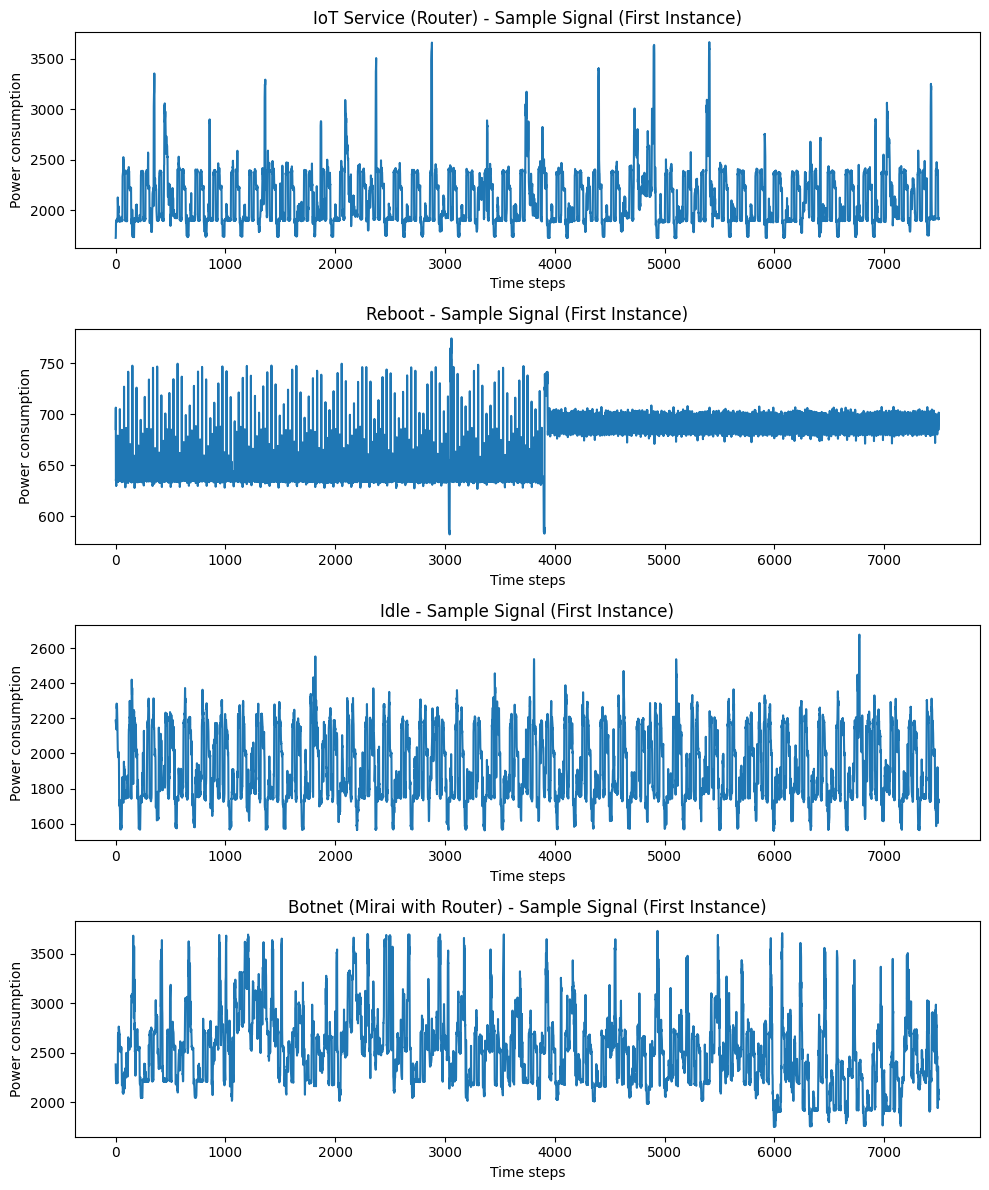

In [40]:
import matplotlib.pyplot as plt

# List of keys to visualize and their friendly names
keys_to_plot = {
    'router': 'IoT Service (Router)',
    'reboot': 'Reboot',
    'idle': 'Idle',
    'mirai_with_router': 'Botnet (Mirai with Router)'
}

fig, axes = plt.subplots(len(keys_to_plot), 1, figsize=(10, 3*len(keys_to_plot)))
if len(keys_to_plot) == 1:
    axes = [axes]  # ensure axes is iterable

for ax, (key, title) in zip(axes, keys_to_plot.items()):
    if key not in data:
        continue
    # data[key] shape is (7500, num_instances), so take first instance
    signal = data[key][:, 0]  # first instance
    ax.plot(signal)
    ax.set_title(f"{title} - Sample Signal (First Instance)")
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Power consumption")
plt.tight_layout()
plt.show()


In [4]:
import torch
from torch.utils.data import Dataset

class CombinedBotnetDataset(Dataset):
    def __init__(self, mat_file, mapping, transform=None):
        """
        Args:
            mat_file (str): Path to the .mat file.
            mapping (dict): Dictionary mapping key names to label integers.
                            For example: {'router': 0, 'reboot': 1, 'idle': 2, 'mirai_with_router': 3}
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Load the MATLAB file
        mat_data = sio.loadmat(mat_file)
        self.data_list = []
        self.labels_list = []
        self.transform = transform
        
        # Loop over each key and label in the mapping
        for key, label in mapping.items():
            if key not in mat_data:
                raise KeyError(f"Key '{key}' not found in the .mat file. Available keys: {mat_data.keys()}")
            # Each key is assumed to have shape (7500, num_instances)
            data_array = mat_data[key]
            # Transpose so that each instance is a row: shape becomes (num_instances, 7500)
            data_array = data_array.T
            self.data_list.append(data_array)
            # Create a label array with the same number of instances
            self.labels_list.append(np.full((data_array.shape[0],), label))
        
        # Concatenate data and labels from all classes
        self.X = np.concatenate(self.data_list, axis=0)  # shape: (total_instances, 7500)
        self.Y = np.concatenate(self.labels_list, axis=0)  # shape: (total_instances,)
        
        # Add a channel dimension for 1D CNN input (expected shape: (instances, channels, length))
        self.X = np.expand_dims(self.X, axis=1)
        
        # Normalize each instance to have zero mean and unit variance
        self.X = (self.X - self.X.mean(axis=-1, keepdims=True)) / (self.X.std(axis=-1, keepdims=True) + 1e-8)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = torch.tensor(self.X[idx], dtype=torch.float32)
        label = torch.tensor(self.Y[idx], dtype=torch.long)
        if self.transform:
            sample = self.transform(sample)
        return sample, label

# Define mapping: key in .mat file -> label
mapping = {
    'router': 0,            # IoT service
    'reboot': 1,            # Reboot
    'idle': 2,              # Idle
    'mirai_with_router': 3  # Botnet (Mirai)
}

# Create dataset and inspect a few samples
dataset = CombinedBotnetDataset(mat_file, mapping)
print("Total dataset size:", len(dataset))
sample0, label0 = dataset[0]
print("Sample 0 shape:", sample0.shape)  # Expecting (1, 7500)
print("Sample 0 label:", label0)


Total dataset size: 8029
Sample 0 shape: torch.Size([1, 7500])
Sample 0 label: tensor(0)


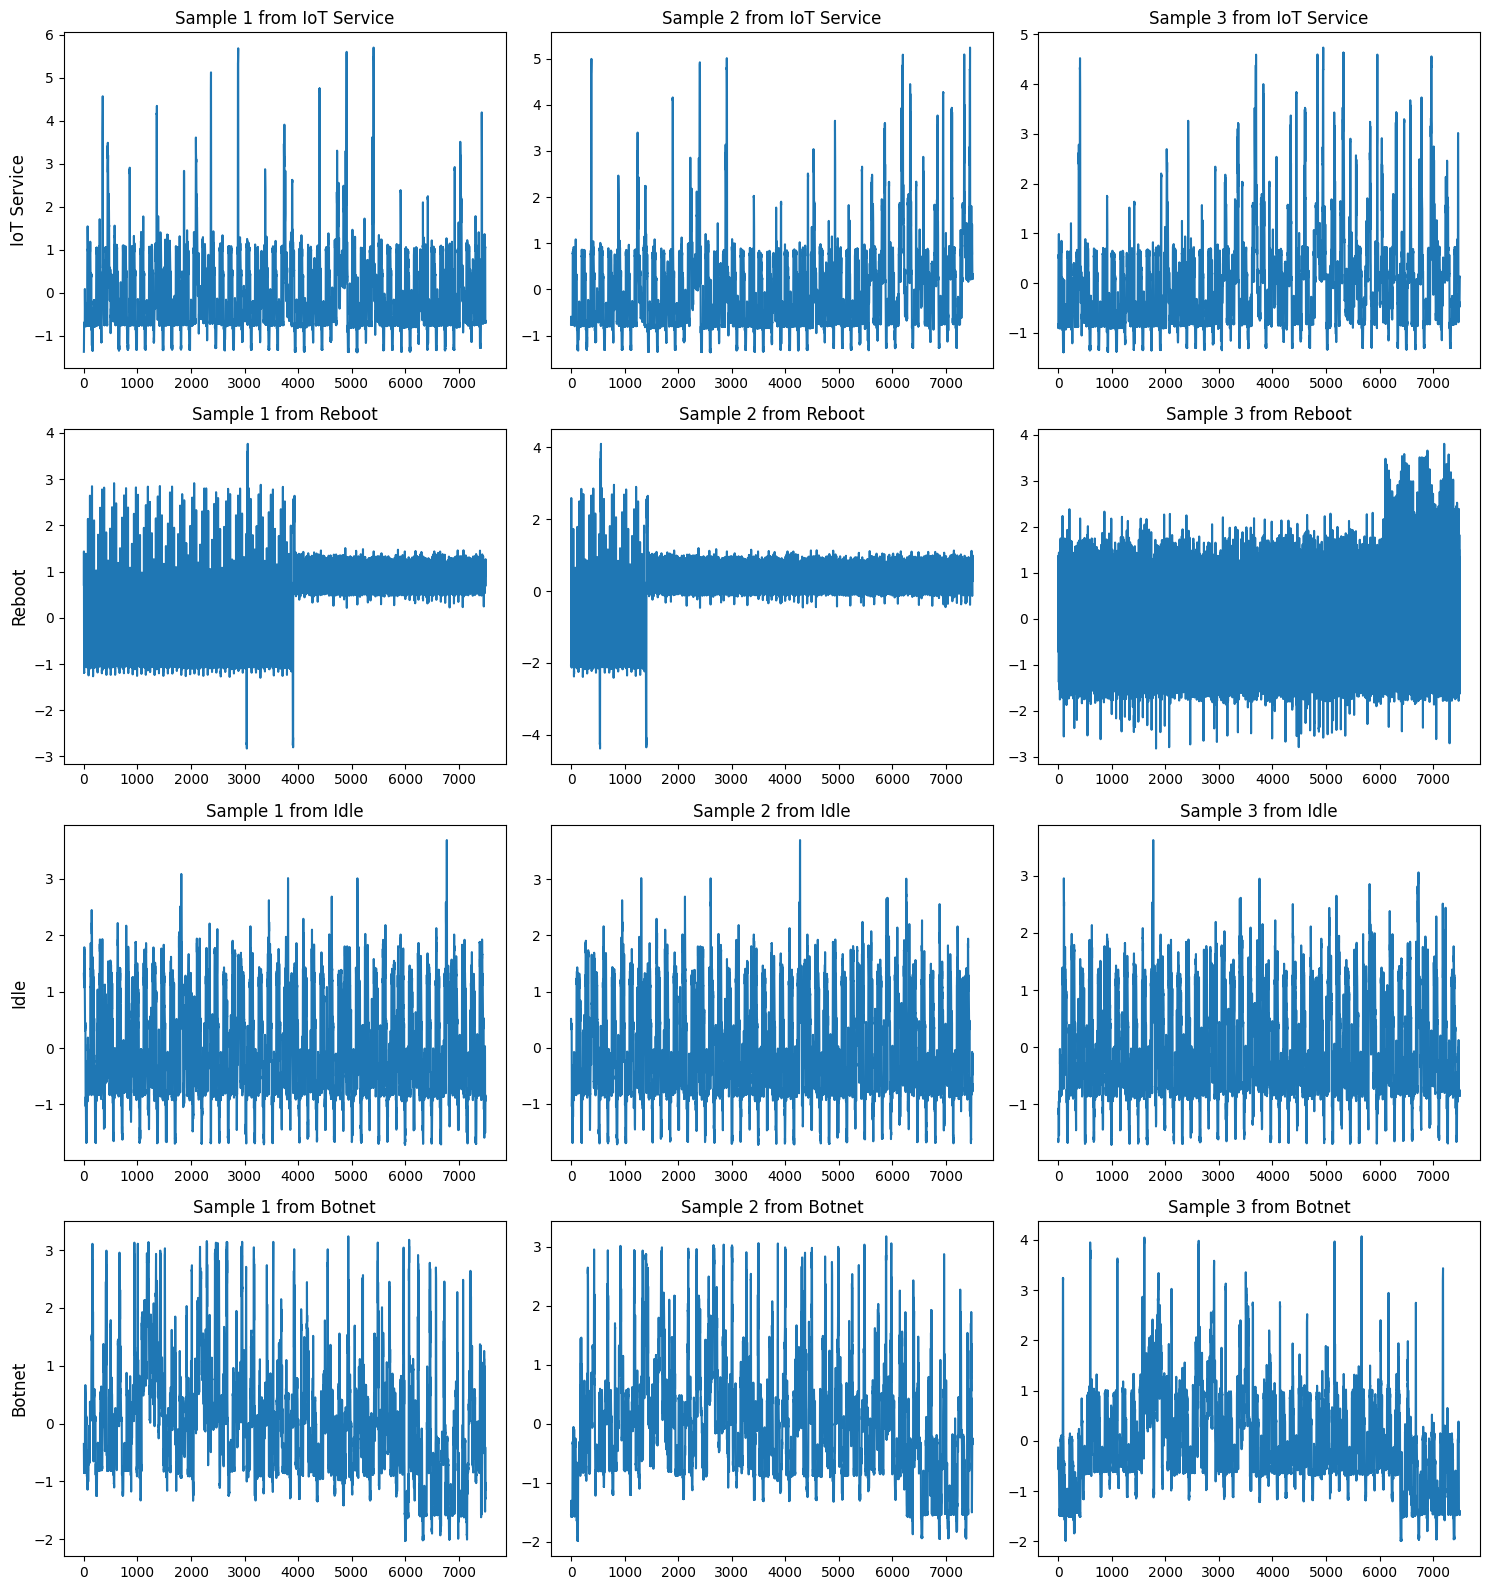

In [5]:
# For each class label, plot a few sample signals from the combined dataset
class_names = ['IoT Service', 'Reboot', 'Idle', 'Botnet']
samples_per_class = 3

fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(15, 4*len(class_names)))
for cls in range(len(class_names)):
    # Find indices corresponding to the class
    indices = np.where(dataset.Y == cls)[0]
    # Select a few samples
    for j in range(samples_per_class):
        if j >= len(indices):
            break
        sample, _ = dataset[indices[j]]
        # sample shape is (1, 7500), squeeze to (7500,)
        axes[cls, j].plot(sample.squeeze().cpu().numpy())
        if j == 0:
            axes[cls, j].set_ylabel(class_names[cls], fontsize=12)
        axes[cls, j].set_title(f"Sample {j+1} from {class_names[cls]}")
plt.tight_layout()
plt.show()


In [6]:
from torch.utils.data import random_split

# Get the total dataset size
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Total samples: 8029
Training samples: 5620
Validation samples: 1204
Test samples: 1205


In [7]:
# Function to count labels in a dataset
def count_labels(subset):
    labels = [label.item() for _, label in subset]
    counts = np.bincount(labels, minlength=len(class_names))
    return counts

train_counts = count_labels(train_dataset)
val_counts = count_labels(val_dataset)
test_counts = count_labels(test_dataset)

print("Label distribution in Training set:", dict(zip(class_names, train_counts)))
print("Label distribution in Validation set:", dict(zip(class_names, val_counts)))
print("Label distribution in Test set:", dict(zip(class_names, test_counts)))


Label distribution in Training set: {'IoT Service': 1711, 'Reboot': 1622, 'Idle': 1721, 'Botnet': 566}
Label distribution in Validation set: {'IoT Service': 370, 'Reboot': 338, 'Idle': 370, 'Botnet': 126}
Label distribution in Test set: {'IoT Service': 388, 'Reboot': 328, 'Idle': 399, 'Botnet': 90}


In [8]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created.")



DataLoaders created.


In [9]:
import torch.nn as nn

class BotnetCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BotnetCNN, self).__init__()
        # 1D Convolution: 10 filters, kernel size 512, stride 128
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=512, stride=128)
        # Batch Normalization after convolution
        self.bn1 = nn.BatchNorm1d(10)
        self.relu = nn.ReLU()
        # Max Pooling: kernel size 4, stride 4
        self.pool = nn.MaxPool1d(kernel_size=4, stride=4)
        
        # Estimate output length:
        # For input length 7500, conv1 output length ≈ floor((7500 - 512)/128) + 1 ≈ 55,
        # then pooling output length ≈ floor((55 - 4)/4) + 1 ≈ 13.
        conv_output_length = 13
        
        # Fully connected layers
        self.fc1 = nn.Linear(10 * conv_output_length, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_bn2 = nn.BatchNorm1d(64)
        # Output layer mapping to num_classes
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, 1, 7500)
        x = self.conv1(x)       # -> (batch, 10, ~55)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)        # -> (batch, 10, ~13)
        x = x.view(x.size(0), -1)  # Flatten: (batch, 10*13)
        x = self.fc1(x)         # -> (batch, 128)
        x = self.fc_bn1(x)
        x = self.relu(x)
        x = self.fc2(x)         # -> (batch, 64)
        x = self.fc_bn2(x)
        x = self.relu(x)
        x = self.fc3(x)         # -> (batch, num_classes)
        return x

# Instantiate the model and print its architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BotnetCNN(num_classes=4).to(device)
print(model)


BotnetCNN(
  (conv1): Conv1d(1, 10, kernel_size=(512,), stride=(128,))
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=130, out_features=128, bias=True)
  (fc_bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc_bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [10]:
import torch.optim as optim

# Hyperparameters
num_epochs = 20
learning_rate = 0.001

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Training for {num_epochs} epochs with learning rate {learning_rate}.")


Training for 20 epochs with learning rate 0.001.


In [11]:
import copy

num_epochs = 20
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training phase
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / total_train
    train_acc = 100. * correct_train / total_train
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / total_val
    val_acc = 100. * correct_val / total_val
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# Load best model weights
model.load_state_dict(best_model_wts)
print("Training complete. Best validation accuracy: {:.2f}%".format(best_val_acc))


Epoch [1/20] - Train Loss: 0.5205, Train Acc: 82.81%, Val Loss: 0.1526, Val Acc: 96.51%
Epoch [2/20] - Train Loss: 0.1185, Train Acc: 97.21%, Val Loss: 0.0969, Val Acc: 97.01%
Epoch [3/20] - Train Loss: 0.0744, Train Acc: 97.92%, Val Loss: 0.1068, Val Acc: 97.18%
Epoch [4/20] - Train Loss: 0.0511, Train Acc: 98.70%, Val Loss: 0.0639, Val Acc: 97.76%
Epoch [5/20] - Train Loss: 0.0421, Train Acc: 98.72%, Val Loss: 0.0755, Val Acc: 97.01%
Epoch [6/20] - Train Loss: 0.0306, Train Acc: 99.16%, Val Loss: 0.0800, Val Acc: 97.67%
Epoch [7/20] - Train Loss: 0.0196, Train Acc: 99.47%, Val Loss: 0.0649, Val Acc: 97.84%
Epoch [8/20] - Train Loss: 0.0203, Train Acc: 99.48%, Val Loss: 0.0616, Val Acc: 97.59%
Epoch [9/20] - Train Loss: 0.0103, Train Acc: 99.77%, Val Loss: 0.0580, Val Acc: 98.01%
Epoch [10/20] - Train Loss: 0.0103, Train Acc: 99.80%, Val Loss: 0.0920, Val Acc: 97.67%
Epoch [11/20] - Train Loss: 0.0155, Train Acc: 99.50%, Val Loss: 0.0895, Val Acc: 97.34%
Epoch [12/20] - Train Loss: 0.

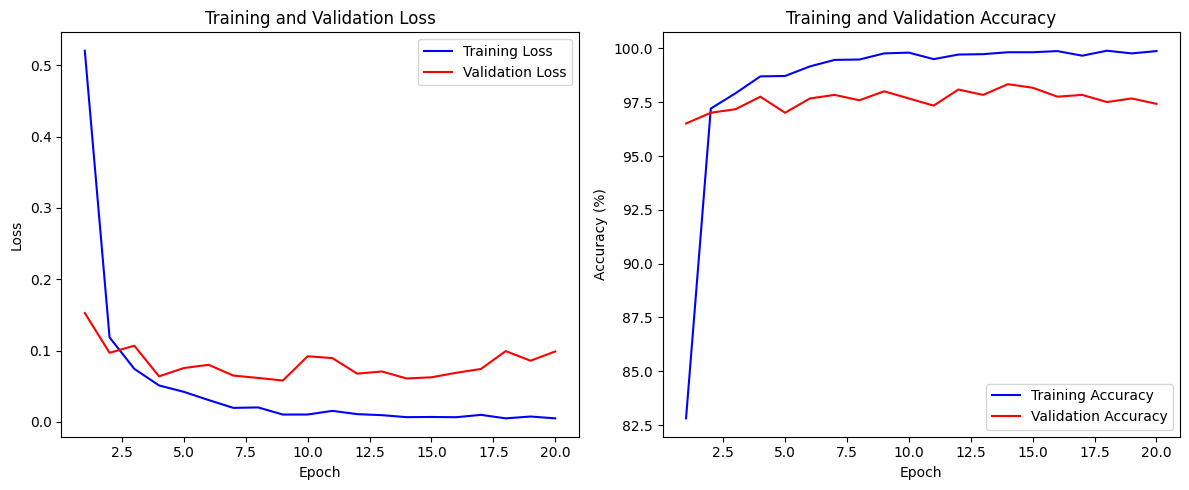

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

 IoT Service       0.99      0.97      0.98       388
      Reboot       1.00      1.00      1.00       328
        Idle       0.99      1.00      0.99       399
      Botnet       0.96      0.97      0.96        90

    accuracy                           0.99      1205
   macro avg       0.98      0.99      0.98      1205
weighted avg       0.99      0.99      0.99      1205



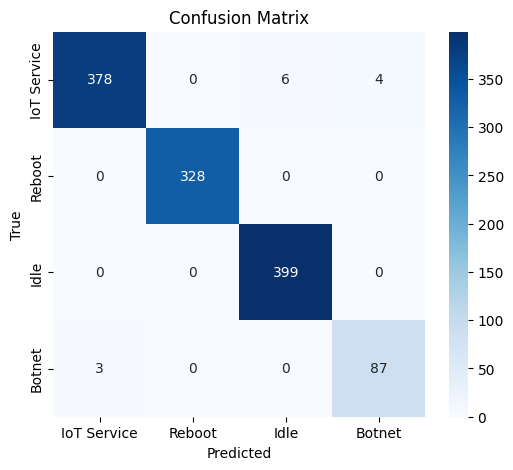

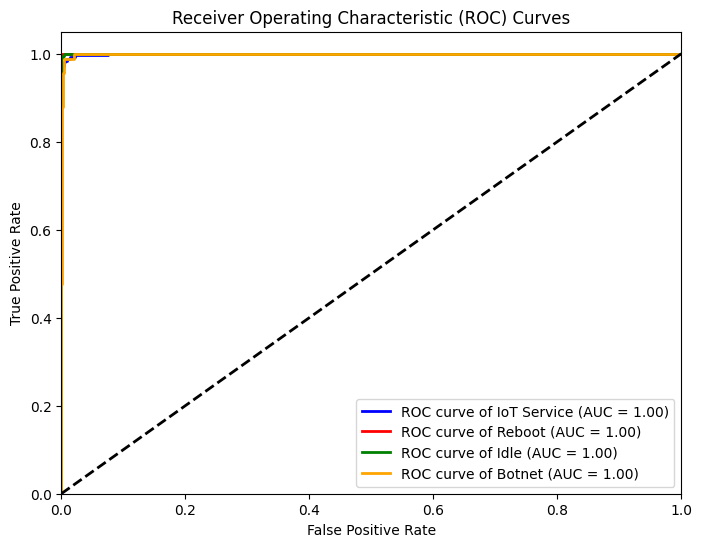

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []
all_outputs = []  # For probability scores

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(probs.cpu().numpy())

# Define class names (adjust if needed)
class_names = ['IoT Service', 'Reboot', 'Idle', 'Botnet']

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC curves (One-vs-Rest)
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_outputs = np.array(all_outputs)

# Binarize the output for ROC (one-hot encoding for labels)
from sklearn.preprocessing import label_binarize
all_labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_outputs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


In [14]:
import scipy.io as sio
import numpy as np
import os

mat_file = os.path.join("Data", "Botnet_Detection.mat")
data = sio.loadmat(mat_file)

# Print keys and shapes
for key in data.keys():
    if key.startswith('__'):
        continue
    arr = data[key]
    print(f"Key: {key}, Shape: {arr.shape}")


Key: camera_motion, Shape: (7500, 1214)
Key: camera_streaming, Shape: (7500, 1356)
Key: extrusion, Shape: (7500, 2816)
Key: idle, Shape: (7500, 2490)
Key: masuta_when_idle, Shape: (7500, 1165)
Key: masuta_with_camera, Shape: (7500, 1157)
Key: mirai_extrusion, Shape: (7500, 2200)
Key: mirai_idle, Shape: (7500, 1534)
Key: mirai_loader, Shape: (7500, 792)
Key: mirai_with_camera, Shape: (7500, 910)
Key: mirai_with_router, Shape: (7500, 782)
Key: mirai_with_voice, Shape: (7500, 1018)
Key: reboot, Shape: (7500, 2288)
Key: router, Shape: (7500, 2469)
Key: router_ftp, Shape: (7500, 640)
Key: voice_assistant, Shape: (7500, 2391)


In [15]:
# Example for Router self-evaluation, based on the README code snippet

# 1) Service class: e.g. combine router(1980) + router_ftp(220) = 2200
service_router = np.hstack([
    data['router'][:, :1980],       # shape: (7500, 1980)
    data['router_ftp'][:, :220]     # shape: (7500, 220)
])  # final shape: (7500, 2200)

# 2) Reboot class: 2200 from the reboot key
reboot_router = data['reboot'][:, :2200]  # shape: (7500, 2200)

# 3) Idle class: 2200 from the idle key
idle_router = data['idle'][:, :2200]      # shape: (7500, 2200)

# 4) Botnet class: combine multiple keys to reach 2200 total
# e.g., mirai_with_router(700) + mirai_idle(800) + mirai_loader(700) = 2200
botnet_router = np.hstack([
    data['mirai_with_router'][:, :700],
    data['mirai_idle'][:, :800],
    data['mirai_loader'][:, :700]
])  # shape: (7500, 2200)

# Stack these 4 classes into a single array, final shape: (7500, 2200*4=8800)
combined_router = np.hstack([
    service_router,
    reboot_router,
    idle_router,
    botnet_router
])  # shape: (7500, 8800)

# Create labels
labels_router = np.concatenate([
    np.full(2200, 0),  # 0=Service
    np.full(2200, 1),  # 1=Reboot
    np.full(2200, 2),  # 2=Idle
    np.full(2200, 3)   # 3=Botnet
])

print("combined_router shape:", combined_router.shape)
print("labels_router shape:", labels_router.shape)


combined_router shape: (7500, 8800)
labels_router shape: (8800,)


In [16]:
import numpy as np

# Assume 'data' is a dictionary loaded from Botnet_Detection.mat,
# with each key being shape (7500, num_instances).

# --------- 1) IoT Service Class (label=0) -----------
# We'll combine 'camera_motion' and 'camera_streaming' for the normal camera service.
# We need a total of 2,200 samples. 
# camera_motion has 1,214, camera_streaming has 1,356 => total 2,570 available.
# So let's pick the first 1,214 from camera_motion, and 986 from camera_streaming.

service_motion = data['camera_motion'][:, :1214]   # shape (7500, 1214)
needed_from_streaming = 2200 - 1214  # 986
service_streaming = data['camera_streaming'][:, :986]  # shape (7500, 986)

service_camera = np.hstack([service_motion, service_streaming])  # shape: (7500, 2200)

# --------- 2) Reboot Class (label=1) -----------
# We'll take 2,200 samples from the 'reboot' key (which has 2,288 total).
reboot_camera = data['reboot'][:, :2200]  # shape (7500, 2200)

# --------- 3) Idle Class (label=2) -----------
# We'll take 2,200 samples from the 'idle' key (which has 2,490 total).
idle_camera = data['idle'][:, :2200]  # shape (7500, 2200)

# --------- 4) Botnet Class (label=3) -----------
# For the camera device, we might combine 'mirai_with_camera' + 'masuta_with_camera' 
# or just pick one. We need a total of 2,200. 
# mirai_with_camera = 910, masuta_with_camera = 1157 => total 2,067
# We still need 133 more to reach 2,200. Possibly we add some 'mirai_loader' or 'mirai_idle'.
# We'll demonstrate adding 'mirai_loader' for the extra 133.

botnet_mirai_cam = data['mirai_with_camera'][:, :910]    # shape (7500, 910)
botnet_masuta_cam = data['masuta_with_camera'][:, :1157]  # shape (7500, 1157)
needed_botnet = 2200 - (910 + 1157)  # 133
botnet_loader_cam = data['mirai_loader'][:, :133]         # shape (7500, 133)

botnet_camera = np.hstack([
    botnet_mirai_cam,
    botnet_masuta_cam,
    botnet_loader_cam
])  # shape (7500, 2200)

# Combine all four classes -> shape: (7500, 8800)
combined_camera = np.hstack([service_camera, reboot_camera, idle_camera, botnet_camera])

# Create labels: total 8,800
labels_camera = np.concatenate([
    np.full(2200, 0),  # IoT Service
    np.full(2200, 1),  # Reboot
    np.full(2200, 2),  # Idle
    np.full(2200, 3)   # Botnet
])

print("combined_camera shape:", combined_camera.shape)  # expect (7500, 8800)
print("labels_camera shape:", labels_camera.shape)       # expect (8800,)


combined_camera shape: (7500, 8800)
labels_camera shape: (8800,)


In [41]:
#Voice Asisitant Combined 
# For the voice device, we have:
# - voice_assistant (7500, 2391)
# - mirai_with_voice (7500, 1018)
# - Possibly extrusions or idle if needed
# - idle (7500, 2490), reboot(7500, 2288)
# - If there's no direct "masuta_with_voice", we can use 'masuta_when_idle' or 'mirai_extrusion' for leftover

# --- Class 1: Service (label=0) ---
# Just take 2200 from voice_assistant
voice_service = data['voice_assistant'][:, :2200]

# --- Class 2: Reboot (label=1) ---
voice_reboot = data['reboot'][:, :2200]

# --- Class 3: Idle (label=2) ---
voice_idle = data['idle'][:, :2200]

# --- Class 4: Botnet (label=3) ---
# We have mirai_with_voice(1018). We need 1182 more to reach 2200.
# Let's use 'mirai_extrusion' or 'extrusion' for leftover.
# For instance, let's pick 1182 from mirai_extrusion(2200).
voice_bot_mirai = data['mirai_with_voice'][:, :1018]
needed_voice_bot = 2200 - 1018  # 1182
voice_bot_extrusion = data['mirai_extrusion'][:, :1182]

voice_botnet = np.hstack([voice_bot_mirai, voice_bot_extrusion])  # (7500, 2200)

combined_voice = np.hstack([
    voice_service,
    voice_reboot,
    voice_idle,
    voice_botnet
])  # (7500, 8800)

labels_voice = np.concatenate([
    np.full(2200, 0),
    np.full(2200, 1),
    np.full(2200, 2),
    np.full(2200, 3)
])

print("combined_voice shape:", combined_voice.shape)  # (7500, 8800)
print("labels_voice shape:", labels_voice.shape)      # (8800,)


combined_voice shape: (7500, 8800)
labels_voice shape: (8800,)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class BotnetEvalDataset(Dataset):
    def __init__(self, data_array, label_array, normalize=True):
        # data_array shape: (7500, num_instances) -> transpose to (num_instances, 7500)
        self.X = data_array.T  # (8800, 7500)
        self.Y = label_array   # (8800,)

        # Add channel dimension for 1D CNN: (num_instances, 1, 7500)
        self.X = np.expand_dims(self.X, axis=1).astype(np.float32)

        if normalize:
            mean = self.X.mean(axis=-1, keepdims=True)
            std = self.X.std(axis=-1, keepdims=True) + 1e-8
            self.X = (self.X - mean) / std

        self.Y = self.Y.astype(np.int64)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.Y[idx], dtype=torch.long)
        )

# Create the dataset for Router self-evaluation
router_dataset = BotnetEvalDataset(combined_router, labels_router)
print("router_dataset length:", len(router_dataset))
camera_dataset = BotnetEvalDataset(combined_camera, labels_camera)
print("router_dataset length:", len(router_dataset))
voice_dataset = BotnetEvalDataset(combined_voice, labels_voice)
print("router_dataset length:", len(router_dataset))


router_dataset length: 8800
router_dataset length: 8800


In [18]:
import math
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 10, kernel_size=512, stride=128)
        self.bn1 = nn.BatchNorm1d(10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=4, stride=4)
        conv_output_length = 13  # approximate
        self.fc1 = nn.Linear(10*conv_output_length, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc_bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc_bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += Y_batch.size(0)
        correct += (predicted == Y_batch).sum().item()
    return running_loss / total, 100.0 * correct / total

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            total += Y_batch.size(0)
            correct += (predicted == Y_batch).sum().item()
    return running_loss / total, 100.0 * correct / total

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
batch_size = 64
num_epochs = 5

X_all = router_dataset.X  # shape: (8800, 1, 7500)
Y_all = router_dataset.Y  # shape: (8800,)

fold_results = []
for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X_all)):
    # Create train/test subsets
    X_train, Y_train = X_all[train_idx], Y_all[train_idx]
    X_test, Y_test = X_all[test_idx], Y_all[test_idx]
    
    # Create DataLoaders
    train_dataset_fold = BotnetEvalDataset(X_train.squeeze(1).T, Y_train, normalize=False)
    test_dataset_fold = BotnetEvalDataset(X_test.squeeze(1).T, Y_test, normalize=False)
    # ^ We remove the channel dimension, then transpose back, then re-init, 
    #   or just keep them as is if you prefer a simpler approach

    train_loader = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset_fold, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = SimpleCNN(num_classes=4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Fold {fold_idx+1}: Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.2f}%")
    fold_results.append(test_acc)

print("K-Fold Results:", fold_results)
print(f"Average Accuracy = {np.mean(fold_results):.2f}%")


Fold 1: Test Loss = 0.0781, Test Acc = 97.78%
Fold 2: Test Loss = 0.0648, Test Acc = 97.61%
Fold 3: Test Loss = 0.0750, Test Acc = 97.84%
Fold 4: Test Loss = 0.0545, Test Acc = 98.47%
Fold 5: Test Loss = 0.0844, Test Acc = 96.93%
K-Fold Results: [97.7840909090909, 97.61363636363636, 97.8409090909091, 98.4659090909091, 96.93181818181819]
Average Accuracy = 97.73%


In [19]:
#1. Cross‐Evaluation

In [20]:
import numpy as np

# For each device, you already have a combined array of shape (7500, 8800) 
# from your "Self-Evaluation" step (2,200 per class × 4 classes).
# Let's say:
#   combined_router, labels_router  # shape: (7500, 8800) and (8800,)
#   combined_camera, labels_camera  # shape: (7500, 8800) and (8800,)

# Now we merge them
combined_cross = np.hstack([combined_router, combined_camera])  # shape (7500, 17600)
labels_cross = np.concatenate([labels_router, labels_camera])   # shape (17600,)

print("Cross-Eval combined shape:", combined_cross.shape)
print("Cross-Eval labels shape:", labels_cross.shape)


Cross-Eval combined shape: (7500, 17600)
Cross-Eval labels shape: (17600,)


In [25]:
import torch
from torch.utils.data import Dataset

class CrossEvalDataset(Dataset):
    def __init__(self, data_array, label_array, normalize=True):
        # data_array shape: (7500, N) -> transpose -> (N, 7500)
        self.X = data_array.T.astype(np.float32)  # shape: (N, 7500)
        # Add channel dimension for 1D conv -> (N, 1, 7500)
        self.X = np.expand_dims(self.X, axis=1)

        if normalize:
            # Per-sample normalization
            mean = self.X.mean(axis=-1, keepdims=True)
            std = self.X.std(axis=-1, keepdims=True) + 1e-8
            self.X = (self.X - mean) / std

        self.Y = label_array.astype(np.int64)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.Y[idx], dtype=torch.long)
        )

# Create the dataset
cross_dataset = CrossEvalDataset(combined_cross, labels_cross)
print("Cross-Eval dataset size:", len(cross_dataset))


Cross-Eval dataset size: 17600


In [26]:
from torch.utils.data import random_split

dataset_size = len(cross_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(cross_dataset, [train_size, test_size])

print(f"Train set size: {len(train_dataset)}, Test set size: {len(test_dataset)}")


Train set size: 14080, Test set size: 3520


In [27]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created.")


DataLoaders created.


In [28]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 10, kernel_size=512, stride=128)
        self.bn1 = nn.BatchNorm1d(10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=4, stride=4)
        conv_output_length = 13  # approximate after conv+pool for input=7500
        self.fc1 = nn.Linear(10 * conv_output_length, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)  # (batch, 10, ~55)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)   # (batch, 10, ~13)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc_bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc_bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=4).to(device)


In [29]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += Y_batch.size(0)
        correct += (predicted == Y_batch).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            total += Y_batch.size(0)
            correct += (predicted == Y_batch).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# Hyperparameters
num_epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")


Epoch 1/10 - Train Loss: 0.4154, Train Acc: 85.10%
Epoch 2/10 - Train Loss: 0.1894, Train Acc: 93.17%
Epoch 3/10 - Train Loss: 0.1528, Train Acc: 94.25%
Epoch 4/10 - Train Loss: 0.1256, Train Acc: 95.46%
Epoch 5/10 - Train Loss: 0.0985, Train Acc: 96.46%
Epoch 6/10 - Train Loss: 0.0837, Train Acc: 96.99%
Epoch 7/10 - Train Loss: 0.0757, Train Acc: 97.19%
Epoch 8/10 - Train Loss: 0.0656, Train Acc: 97.64%
Epoch 9/10 - Train Loss: 0.0550, Train Acc: 98.00%
Epoch 10/10 - Train Loss: 0.0566, Train Acc: 97.91%


Test Loss: 0.0882, Test Accuracy: 97.41%
Classification Report:
              precision    recall  f1-score   support

     Service       0.96      0.94      0.95       891
      Reboot       0.97      0.98      0.97       939
        Idle       1.00      1.00      1.00       851
      Botnet       0.97      0.98      0.97       839

    accuracy                           0.97      3520
   macro avg       0.97      0.97      0.97      3520
weighted avg       0.97      0.97      0.97      3520



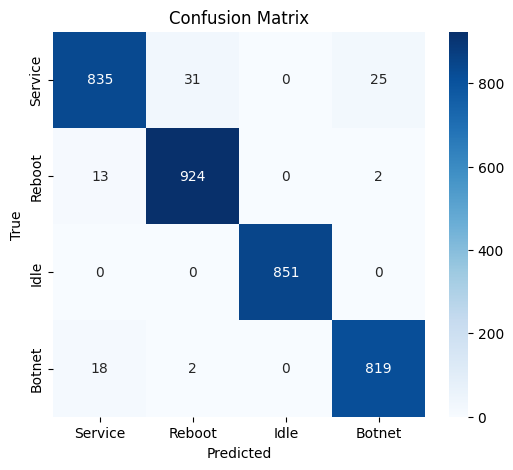

In [30]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Collect all predictions and labels for confusion matrix
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(Y_batch.cpu().numpy())

# Classification report
class_names = ['Service', 'Reboot', 'Idle', 'Botnet']  # adjust if needed
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [31]:
import numpy as np

# Suppose you have these from your self-evaluation steps:
#   combined_camera, labels_camera   # shape: (7500, 8800), (8800,)
#   combined_router, labels_router   # shape: (7500, 8800), (8800,)
#   combined_voice, labels_voice     # shape: (7500, 8800), (8800,)

device_data = {
    'camera': {
        'X': combined_camera,  # shape (7500, 8800)
        'Y': labels_camera     # shape (8800,)
    },
    'router': {
        'X': combined_router,
        'Y': labels_router
    },
    # 'voice': {
    #     'X': combined_voice,
    #     'Y': labels_voice
    # }
}

print("Devices in device_data:", list(device_data.keys()))
for dev in device_data:
    print(f"{dev} -> X shape: {device_data[dev]['X'].shape}, Y shape: {device_data[dev]['Y'].shape}")


Devices in device_data: ['camera', 'router']
camera -> X shape: (7500, 8800), Y shape: (8800,)
router -> X shape: (7500, 8800), Y shape: (8800,)


In [32]:
import torch
from torch.utils.data import Dataset

class LODODataset(Dataset):
    def __init__(self, X_array, Y_array, normalize=True):
        """
        X_array: shape (7500, N)
        Y_array: shape (N,)
        """
        # Transpose to (N, 7500)
        self.X = X_array.T.astype(np.float32)  # (N, 7500)
        # Add channel dimension for 1D conv -> (N, 1, 7500)
        self.X = np.expand_dims(self.X, axis=1)
        
        if normalize:
            mean = self.X.mean(axis=-1, keepdims=True)
            std = self.X.std(axis=-1, keepdims=True) + 1e-8
            self.X = (self.X - mean) / std
        
        self.Y = Y_array.astype(np.int64)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.Y[idx], dtype=torch.long)
        )


In [33]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 10, kernel_size=512, stride=128)
        self.bn1 = nn.BatchNorm1d(10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=4, stride=4)
        
        # Approximate output length after conv+pool
        conv_output_length = 13  # for 7500 input
        self.fc1 = nn.Linear(10*conv_output_length, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x shape: (batch, 1, 7500)
        x = self.conv1(x)       # -> (batch, 10, ~55)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)        # -> (batch, 10, ~13)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc_bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc_bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


In [34]:
import torch.optim as optim
from torch.utils.data import DataLoader

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += Y_batch.size(0)
        correct += (predicted == Y_batch).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            total += Y_batch.size(0)
            correct += (predicted == Y_batch).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
devices = list(device_data.keys())  # e.g. ['camera', 'router', 'voice']

num_epochs = 5
batch_size = 64
learning_rate = 0.001

results = {}

criterion = nn.CrossEntropyLoss()

for left_out_device in devices:
    print(f"\n--- LODO: Leaving out {left_out_device} ---")
    
    # Combine data from the other devices for training
    train_X_list = []
    train_Y_list = []
    for dev in devices:
        if dev == left_out_device:
            continue
        train_X_list.append(device_data[dev]['X'])
        train_Y_list.append(device_data[dev]['Y'])
    
    # Stack training data
    train_X = np.hstack(train_X_list)  # shape: (7500, total_train_samples)
    train_Y = np.concatenate(train_Y_list)  # shape: (total_train_samples,)
    
    # Test data from the left-out device
    test_X = device_data[left_out_device]['X']
    test_Y = device_data[left_out_device]['Y']
    
    # Create Datasets
    train_dataset = LODODataset(train_X, train_Y, normalize=True)
    test_dataset = LODODataset(test_X, test_Y, normalize=True)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = SimpleCNN(num_classes=4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train for a few epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        # (Optional) Print training progress
        # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    # Evaluate on the left-out device
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    results[left_out_device] = test_acc
    print(f"Left Out: {left_out_device}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("\nLODO Results:", results)



--- LODO: Leaving out camera ---
Left Out: camera, Test Loss: 2.0686, Test Acc: 63.93%

--- LODO: Leaving out router ---
Left Out: router, Test Loss: 1.8910, Test Acc: 74.83%

LODO Results: {'camera': 63.93181818181818, 'router': 74.82954545454545}


Classification Report:
              precision    recall  f1-score   support

     Service       0.27      0.00      0.01      2200
      Reboot       1.00      0.99      1.00      2200
        Idle       0.78      1.00      0.88      2200
      Botnet       0.58      1.00      0.73      2200

    accuracy                           0.75      8800
   macro avg       0.66      0.75      0.65      8800
weighted avg       0.66      0.75      0.65      8800



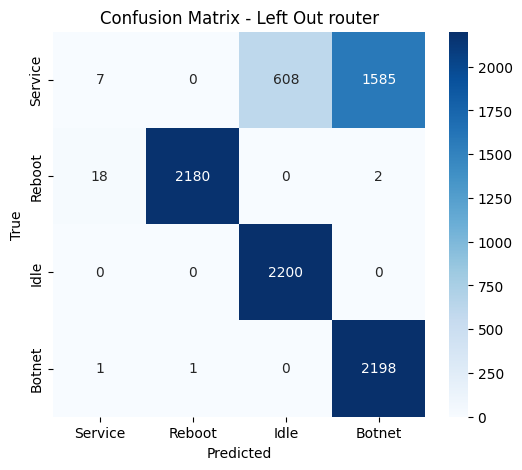

In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Example for one device (if you want to do it in the loop above, you can do so):
left_out = 'router'  # for instance
test_X = device_data[left_out]['X']
test_Y = device_data[left_out]['Y']

test_dataset = LODODataset(test_X, test_Y, normalize=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(Y_batch.cpu().numpy())

class_names = ['Service', 'Reboot', 'Idle', 'Botnet']
cm = confusion_matrix(all_labels, all_preds)
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Left Out {left_out}")
plt.show()
